# Step 2 - EDA
    Análise exploratória dos dados
    Criação da matriz esparsa
    Problemas de cold start
    Cálculo de similaridade
    Redução de dimensionalidade com TruncatedSVD

###### Imports

In [1]:
import pandas as pd
import numpy as np

from scipy import sparse

from datetime import datetime

from sklearn.decomposition import TruncatedSVD

# warnings
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")  

###### Carregando bases (geradas no step 1)

In [2]:
df_treino = pd.read_csv('archive/dataset_treino.csv.gz')
df_teste = pd.read_csv('archive/dataset_teste.csv.gz')

df_treino.data = pd.to_datetime(df_treino.data)
df_treino['dia_mes'] = [i.day for i in df_treino['data']]

dias = [
    'Segunda',
    'Terça',
    'Quarta',
    'Quinta',
    'Sexta',
    'Sábado',
    'Domingo'
]
df_treino['num_dia_semana'] = [i.weekday() for i in df_treino['data']]
df_treino['dia_semana'] = [dias[i] for i in df_treino['num_dia_semana']]
df_treino['mes'] = [i.month for i in df_treino['data']]

#df_treino['dia_semana'] = df_treino['data'].dt.strftime("%A")
df_treino.head()

,filme,usuario,avaliacao,data,dia_mes,num_dia_semana,dia_semana,mes
0,10341,510180,4,1999-11-11,11,3,Quinta,11
1,17764,510180,5,1999-11-11,11,3,Quinta,11
2,1367,510180,5,1999-11-11,11,3,Quinta,11
3,8079,510180,2,1999-11-11,11,3,Quinta,11
4,15105,510180,4,1999-11-11,11,3,Quinta,11


#### Quantidades de usuários, filmes e avaliações

In [3]:
print('Quantidade de usuários avaliando:', df_treino.usuario.nunique())
print('Quantidade de filmes avaliados:', df_treino.filme.nunique())
print('Quantidade de avaliações:', df_treino.shape[0])

Quantidade de usuários avaliando: 405035
Quantidade de filmes avaliados: 17425
Quantidade de avaliações: 80384405


#### Período analisado

In [4]:
print('Data mínima:', df_treino.data.min())
print('Data máxima:', df_treino.data.max())
print('duração período', (df_treino.data.max()-df_treino.data.min()))

Data mínima: 1999-11-11 00:00:00
Data máxima: 2005-08-08 00:00:00
duração período 2097 days 00:00:00


#### Verificando nulos

In [5]:
df_treino.isnull().sum()

filme             0
usuario           0
avaliacao         0
data              0
dia_mes           0
num_dia_semana    0
dia_semana        0
mes               0
dtype: int64

#### Describe

In [6]:
df_treino.describe()

,filme,usuario,avaliacao,dia_mes,num_dia_semana,mes
count,8.038440e+07,8.038440e+07,8.038440e+07,8.038440e+07,8.038440e+07,8.038440e+07
mean,9.038531e+03,1.321508e+06,3.582852e+00,1.558192e+01,2.607768e+00,5.965377e+00
std,5.134194e+03,7.646536e+05,1.082972e+00,8.875925e+00,1.935246e+00,3.294635e+00
min,1.000000e+00,6.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00
25%,4.652000e+03,6.606360e+05,3.000000e+00,8.000000e+00,1.000000e+00,3.000000e+00
50%,8.989000e+03,1.317009e+06,4.000000e+00,1.600000e+01,2.000000e+00,6.000000e+00
75%,1.361400e+04,1.983562e+06,4.000000e+00,2.300000e+01,4.000000e+00,8.000000e+00
max,1.777000e+04,2.649429e+06,5.000000e+00,3.100000e+01,6.000000e+00,1.200000e+01


#### Verificando duplicidade

In [7]:
sum(df_treino.duplicated(['filme', 'usuario', 'avaliacao']))

0

#### Verificando distribuição das avaliações

In [8]:
df_treino.avaliacao.value_counts(normalize=True).sort_index()

1    0.046543
2    0.104128
3    0.290349
4    0.337891
5    0.221088
Name: avaliacao, dtype: float64

#### Média de avaliações

In [9]:
df_treino.avaliacao.mean()

3.5828520594262034

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

#### Função para ajuste das unidades de medida para deixar visualização mais agradável

In [11]:
def ajusta_unidades(num, units = 'M'):
    units = units.lower()
    num = float(num)
    if units == 'k':
        return str(num/10**3) + " K"
    elif units == 'm':
        return str(num/10**6) + " M"
    elif units == 'b':
        return str(num/10**9) +  " B"

#### Distribuição das Avaliações

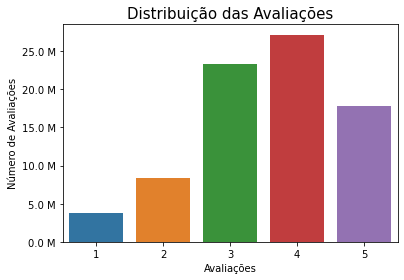

In [12]:
# Plot
fig, ax = plt.subplots()
plt.title('Distribuição das Avaliações', fontsize = 15)
sns.countplot(df_treino.avaliacao)
ax.set_xlabel('Avaliações')
ax.set_ylabel('Número de Avaliações')

ax.set_yticklabels([ajusta_unidades(item, 'M') for item in ax.get_yticks()])

plt.show()

#### Distribuição das Avaliações por dia da semana

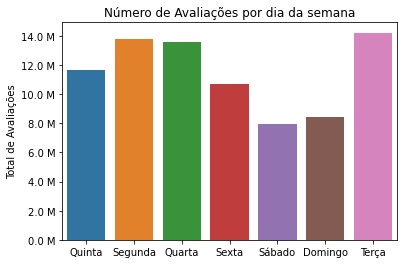

In [13]:
# Plot
fig, ax = plt.subplots()
sns.countplot(x = 'dia_semana', data = df_treino, ax = ax)
plt.title('Número de Avaliações por dia da semana')
plt.ylabel('Total de Avaliações')
plt.xlabel('')
ax.set_yticklabels([ajusta_unidades(item, 'M') for item in ax.get_yticks()])
plt.show()

#### Criando período do mês

In [14]:
conditions = [
    (df_treino['dia_mes'] < 11),
    ((df_treino['dia_mes'] >= 11) & (df_treino['dia_mes'] <=20)),
    (df_treino['dia_mes'] > 20)
    ]

values = ['inicio', 'meio', 'final']
df_treino['periodo_mes'] = np.select(conditions, values)

In [15]:
df_treino.head()

,filme,usuario,avaliacao,data,dia_mes,num_dia_semana,dia_semana,mes,periodo_mes
0,10341,510180,4,1999-11-11,11,3,Quinta,11,meio
1,17764,510180,5,1999-11-11,11,3,Quinta,11,meio
2,1367,510180,5,1999-11-11,11,3,Quinta,11,meio
3,8079,510180,2,1999-11-11,11,3,Quinta,11,meio
4,15105,510180,4,1999-11-11,11,3,Quinta,11,meio


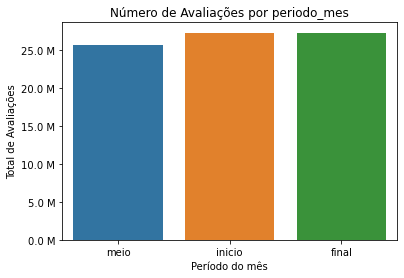

In [16]:
# Plot
fig, ax = plt.subplots()
sns.countplot(x = 'periodo_mes', data = df_treino, ax = ax)
plt.title('Número de Avaliações por periodo_mes')
plt.ylabel('Total de Avaliações')
plt.xlabel('Período do mês')
ax.set_yticklabels([ajusta_unidades(item, 'M') for item in ax.get_yticks()])
plt.show()

In [17]:
#media por mes
print('media por mês')
df_treino.groupby('mes')['avaliacao'].mean()

media por mês


mes
1     3.551074
2     3.556291
3     3.579496
4     3.590111
5     3.592810
6     3.613396
7     3.624679
8     3.569686
9     3.550485
10    3.578523
11    3.567319
12    3.578930
Name: avaliacao, dtype: float64

In [18]:
#media por dia
print('media por dia do mês')
df_treino.groupby('dia_mes')['avaliacao'].mean()

media por dia do mês


dia_mes
1     3.590053
2     3.576557
3     3.575087
4     3.583554
5     3.585278
6     3.593772
7     3.591330
8     3.580380
9     3.563408
10    3.575705
11    3.573306
12    3.572071
13    3.577663
14    3.573495
15    3.598314
16    3.580969
17    3.578229
18    3.580076
19    3.591993
20    3.590178
21    3.586521
22    3.581881
23    3.581880
24    3.583533
25    3.588038
26    3.583698
27    3.592250
28    3.590879
29    3.580967
30    3.577262
31    3.583677
Name: avaliacao, dtype: float64

In [19]:
#media por dia da semana
print('media por dia da semana')
df_treino.groupby('dia_semana')['avaliacao'].mean()

media por dia da semana


dia_semana
Domingo    3.594144
Quarta     3.583751
Quinta     3.582463
Segunda    3.577025
Sexta      3.585274
Sábado     3.591791
Terça      3.574438
Name: avaliacao, dtype: float64

### Em geral o mês, dia do mês ou dia da semana não interferem na avaliação
## ----------

In [20]:
df_treino.head()

,filme,usuario,avaliacao,data,dia_mes,num_dia_semana,dia_semana,mes,periodo_mes
0,10341,510180,4,1999-11-11,11,3,Quinta,11,meio
1,17764,510180,5,1999-11-11,11,3,Quinta,11,meio
2,1367,510180,5,1999-11-11,11,3,Quinta,11,meio
3,8079,510180,2,1999-11-11,11,3,Quinta,11,meio
4,15105,510180,4,1999-11-11,11,3,Quinta,11,meio


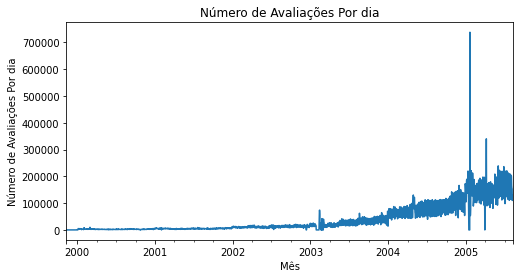

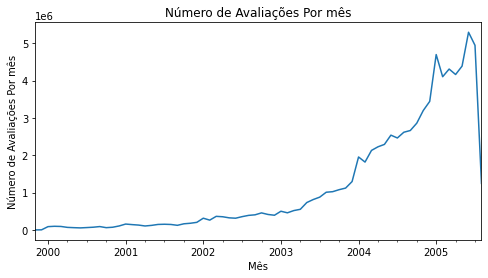

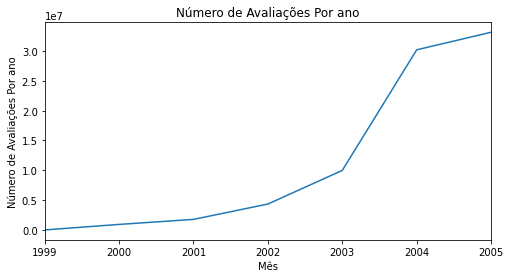

In [21]:
# Plot
fig = plt.figure(figsize = plt.figaspect(.50))
ax = df_treino.resample('d', on = 'data')['avaliacao'].count().plot()
ax.set_title('Número de Avaliações Por dia')
plt.xlabel('Mês')
plt.ylabel('Número de Avaliações Por dia')
plt.show()

# Plot
fig = plt.figure(figsize = plt.figaspect(.50))
ax = df_treino.resample('m', on = 'data')['avaliacao'].count().plot()
ax.set_title('Número de Avaliações Por mês')
plt.xlabel('Mês')
plt.ylabel('Número de Avaliações Por mês')
plt.show()

# Plot
fig = plt.figure(figsize = plt.figaspect(.50))
ax = df_treino.resample('y', on = 'data')['avaliacao'].count().plot()
ax.set_title('Número de Avaliações Por ano')
plt.xlabel('Mês')
plt.ylabel('Número de Avaliações Por ano')
plt.show()

### Aumento de avaliações com o passar do tempo, o que faz sentido, mais pessoas utilizando o netflix
## ----------

#### Histograma

array([[<AxesSubplot:title={'center':'avaliacao'}>,
        <AxesSubplot:title={'center':'dia_mes'}>],
       [<AxesSubplot:title={'center':'filme'}>,
        <AxesSubplot:title={'center':'mes'}>],
       [<AxesSubplot:title={'center':'num_dia_semana'}>,
        <AxesSubplot:title={'center':'usuario'}>]], dtype=object)

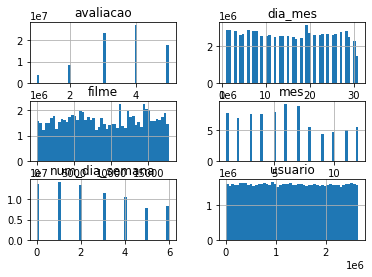

In [22]:
df_treino.hist(bins=50)

#### Quantidade de avaliações por usuário

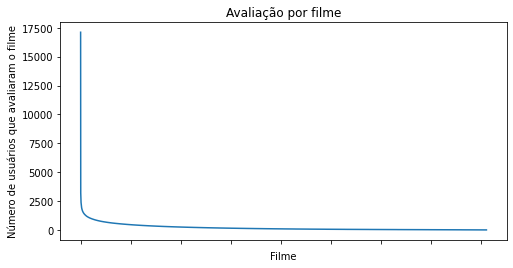

In [23]:
num_avaliacao_por_usuario = df_treino.groupby(by = 'usuario')['avaliacao'].count().sort_values(ascending = False)

fig = plt.figure(figsize=plt.figaspect(.5))
ax = plt.gca()
plt.plot(num_avaliacao_por_usuario.values)
plt.title('Avaliação por filme')
plt.xlabel('Filme')
plt.ylabel('Número de usuários que avaliaram o filme')
ax.set_xticklabels([])

plt.show()

###### Início do gráfico alto, alguns filmes que são avaliados por um grande número de usuários (filmes mais populares)

###### Mas a maioria dos filmes (curva descendo - maior parte do gráfico pra baixo) tem menos avaliações (algumas centenas)

###### -------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### Percentis

In [24]:
percentis = num_avaliacao_por_usuario.quantile(np.arange(0,1.01,0.01), interpolation = 'higher')

In [25]:
percentis[::5]

0.00        1
0.05        7
0.10       15
0.15       21
0.20       27
0.25       34
0.30       41
0.35       50
0.40       60
0.45       73
0.50       89
0.55      109
0.60      133
0.65      163
0.70      199
0.75      245
0.80      307
0.85      392
0.90      520
0.95      749
1.00    17111
Name: avaliacao, dtype: int64

#### Quantas avaliações estão nos últimos 5% de todas as avaliações

In [26]:
print('\n Quantidade de avaliações que estão nos últimos 5%: ', sum(num_avaliacao_por_usuario>= 749)) 


 Quantidade de avaliações que estão nos últimos 5%:  20301


#### 95% da base (filmes) tem até 749.0 avaliações

In [27]:
print('\n 95% da base(filmes) tem até',num_avaliacao_por_usuario.quantile(0.95),'avaliações')


 95% da base(filmes) tem até 749.0 avaliações


###### Observa-se que a maior parte dos filmes (90%) tem até 749 avaliações, os outros 5% totalizam 20305 avaliações

# --------------------------------------------------------------------------------------------------------

# --------------------------------------------------------------------------------------------------------

# Criação da Matriz Esparsa

### Treino

In [28]:
matriz_esparsa_treino = sparse.csr_matrix((df_treino.avaliacao.values, 
                                           (df_treino.usuario.values,
                                            df_treino.filme.values)),)
print('shape: ', matriz_esparsa_treino.shape)
sparse.save_npz("archive/matriz_esparsa_treino.npz", matriz_esparsa_treino)

shape:  (2649430, 17771)


###### Cálculo da esparsidade da matriz

In [29]:
linhas, colunas = matriz_esparsa_treino.shape
elementos_nao_zero = matriz_esparsa_treino.count_nonzero()
print('Esparsidade:', (1 - (elementos_nao_zero / (linhas * colunas))) * 100)

Esparsidade: 99.8292709259195


###### ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### Teste

In [30]:
matriz_esparsa_teste = sparse.csr_matrix((df_teste.avaliacao.values, (df_teste.usuario.values,
                                                              df_teste.filme.values)),)
print('shape: ', matriz_esparsa_teste.shape)
sparse.save_npz("archive/matriz_esparsa_teste.npz", matriz_esparsa_teste)

shape:  (2649430, 17771)


###### Cálculo da esparsidade da matriz

In [31]:
linhas, colunas = matriz_esparsa_teste.shape
elementos_nao_zero = matriz_esparsa_teste.count_nonzero()
print('Esparsidade:', (1 - (elementos_nao_zero / (linhas * colunas))) * 100)

Esparsidade: 99.95731772988694


###### ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

#### Função para cálculo da média de avaliações por usuário e por filme

In [32]:
# Abaixo calculamos a média global de todas as avaliações de usuários.
medias_treino = dict()
medias_treino_global = matriz_esparsa_treino.sum() / matriz_esparsa_treino.count_nonzero() #nonzero -- retira zeros para cálculo
medias_treino['global'] = medias_treino_global
medias_treino

{'global': 3.5828520594262034}

In [33]:
# Função de cálculo da média
def calcula_media_avaliacoes(sparse_matrix, of_users):
    
    # Média de avaliações de usuários/eixos
    # 1 = eixo de usuário
    # 0 = eixo de filme
    ax = 1 if of_users else 0

    # Soma
    sum_of_ratings = sparse_matrix.sum(axis=ax).A1
    
    # Matriz booleana de avaliações ( se um usuário avaliou um filme ou não )
    is_rated = sparse_matrix!=0
    
    # Número de avaliações de cada usuário ou filme
    no_of_ratings = is_rated.sum(axis=ax).A1
    
    # Ids máximos de usuário e filmes na matriz esparsa
    u, m = sparse_matrix.shape
    
    # Criamos um dicionário de usuários e suas avaliações médias.
    media_aval = {i:sum_of_ratings[i]/no_of_ratings[i] for i in range(u if of_users else m) if no_of_ratings[i]!=0}

    # Retorna o dicionário de médias de avaliações
    return media_aval

In [34]:
# Média de avaliações de usuários
medias_treino['usuario'] = calcula_media_avaliacoes(matriz_esparsa_treino, of_users = True)

In [35]:
print('Média de Avaliação do Usuário 10 :', medias_treino['usuario'][10])

Média de Avaliação do Usuário 10 : 3.399014778325123


In [36]:
# Média de avaliações por filme
medias_treino['filme'] =  calcula_media_avaliacoes(matriz_esparsa_treino, of_users = False)

In [37]:
print('Média de Avaliação do filme 10 :', medias_treino['filme'][10])

Média de Avaliação do filme 10 : 3.1945701357466065


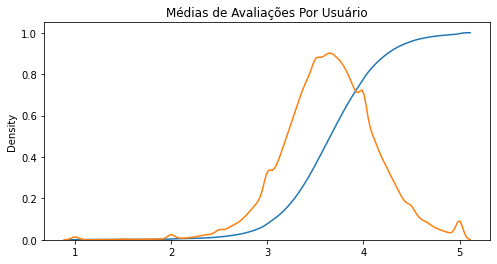

In [38]:
fig = plt.figure(figsize=plt.figaspect(.5))
ax = plt.gca()
plt.title('Médias de Avaliações Por Usuário')
medias_usuarios = [rat for rat in medias_treino['usuario'].values()]

sns.distplot(medias_usuarios, ax = ax, hist = False, kde_kws = dict(cumulative = True), label = 'CDF')
sns.distplot(medias_usuarios, ax = ax, hist = False, label = 'PDF')

plt.show()

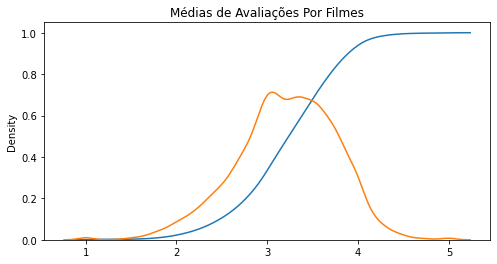

In [39]:
fig = plt.figure(figsize=plt.figaspect(.5))
ax = plt.gca()
plt.title('Médias de Avaliações Por Filmes')
medias_filmes = [rat for rat in medias_treino['filme'].values()]

sns.distplot(medias_filmes, ax = ax, hist = False, kde_kws = dict(cumulative = True), label = 'CDF')
sns.distplot(medias_filmes, ax = ax, hist = False, label = 'PDF')

plt.show()

# --------------------------------------------------------------------------------------------------------

# Problema do cold start
    É a situação em que encontramos novas amostras, ou com baixa popularidade por não ter dados suficiente para recomendar e acaba deixando eles fora das recomendações. O filme pode não ter aparecido na base de treino e só aparecer na de teste, por exemplo. O problema de recomendação de filmes novos é chamado de Cold Start Problem.

In [40]:
df = pd.read_csv('archive/dataset.csv', sep = ',', names = ['filme', 'usuario', 'avaliacao', 'data'])
total_de_usuarios = len(np.unique(df.usuario))
total_de_filmes = len(np.unique(df.filme))
del(df)

In [41]:
usuarios_treino = len(medias_treino['usuario'])
novos_usuarios = total_de_usuarios - usuarios_treino

In [42]:
# Print
print('Total Geral de Usuários:', total_de_usuarios)
print('Total de Usuários em Treino :', usuarios_treino)
print("Total de Usuários Que Não Estão em Treino: {} ({}%)".format(novos_usuarios,
                                                                   np.round((novos_usuarios / total_de_usuarios) * 100, 2)))

Total Geral de Usuários: 480189
Total de Usuários em Treino : 405035
Total de Usuários Que Não Estão em Treino: 75154 (15.65%)


75148 usuários não fazem parte dos dados de treino, ou seja, não temos como aprender o padrão de avaliação desses usuários.

In [43]:
# Cold start de filmes
filmes_treino = len(medias_treino['filme'])
novos_filmes = total_de_filmes - filmes_treino

In [44]:
# Print
print('Total Geral de Filmes:', total_de_filmes)
print('Total de Filmes em Treino:', filmes_treino)
print("Total de Filmes Que Não Estão em Treino: {} ({}%)".format(novos_filmes,
                                                                 np.round((novos_filmes/total_de_filmes)*100, 2)))

Total Geral de Filmes: 17770
Total de Filmes em Treino: 17425
Total de Filmes Que Não Estão em Treino: 345 (1.94%)


346 filmes não aparecem nos dados de treino.

# --------------------------------------------------------------------------------------------------------

# Cálculo da similaridade
    Calcular similaridade entre usuário e entre filme, juntar isso e fazer as recomendações

In [45]:
def calcula_similaridade_usuario(sparse_matrix, 
                                 compute_for_few = False, 
                                 top = 100, 
                                 verbose = False, 
                                 verb_for_n_rows = 20,
                                 draw_time_taken = True):
    '''
    Utilização da Matriz esparsa para cálculos, por quê?
    Temos que trabalhar com esparsidade neste caso, porque não temos avaliação para todos os filmes
    '''
    
    # Variáveis de controle
    no_of_users, _ = sparse_matrix.shape
    row_ind, col_ind = sparse_matrix.nonzero()
    row_ind = sorted(set(row_ind)) 
    time_taken = list()
    rows, cols, data = list(), list(), list()
    if verbose: print("Calculando top", top, "similaridades para cada usuário...")
    start = datetime.now()
    temp = 0
    
    # Loop pela matriz
    for row in row_ind[:top] if compute_for_few else row_ind:
        temp = temp + 1
        prev = datetime.now()
        
        # Calculando a similaridade de cosseno
        # pega uma linha inteira da matriz esparsa e calcula a similaridade para toda a matriz
        sim = cosine_similarity(sparse_matrix.getrow(row), sparse_matrix).ravel()
        
        top_sim_ind = sim.argsort()[-top:]
        top_sim_val = sim[top_sim_ind]
        rows.extend([row]*top)
        cols.extend(top_sim_ind)
        data.extend(top_sim_val)
        time_taken.append(datetime.now().timestamp() - prev.timestamp())
        
        if verbose:
            if temp%verb_for_n_rows == 0:
                print("Cálculo concluído para {} usuários [  tempo total : {}  ]".format(temp, datetime.now()-start))
            
    if verbose: print('Criação de matriz esparsa a partir das semelhanças computadas...')    
        
    if draw_time_taken:
        plt.plot(time_taken, label = 'Tempo de cálculo de cada usuário')
        plt.plot(np.cumsum(time_taken), label = 'Tempo Total')
        plt.legend(loc = 'best')
        plt.xlabel('Usuário')
        plt.ylabel('Tempo (segundos)')
        plt.show()
        
    return sparse.csr_matrix((data, (rows, cols)), shape = (no_of_users, no_of_users)), time_taken      

In [46]:
from sklearn.metrics.pairwise import cosine_similarity

Calculando top 100 similaridades para cada usuário...
Cálculo concluído para 20 usuários [  tempo total : 0:01:08.803024  ]
Cálculo concluído para 40 usuários [  tempo total : 0:02:16.994452  ]
Cálculo concluído para 60 usuários [  tempo total : 0:03:24.592038  ]
Cálculo concluído para 80 usuários [  tempo total : 0:04:32.285767  ]
Cálculo concluído para 100 usuários [  tempo total : 0:05:41.967959  ]
Criação de matriz esparsa a partir das semelhanças computadas...


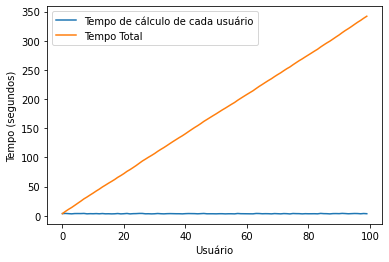

Tempo execução: 0:05:53.769401


In [47]:
begin = datetime.now()

# Aplicando função
matriz_esparsa_user, _ = calcula_similaridade_usuario(matriz_esparsa_treino, 
                                                      compute_for_few = True, 
                                                      top = 100, 
                                                      verbose = True)

print('Tempo execução:', datetime.now() - begin)

In [48]:
df_treino.usuario.nunique()

405035

Como tem muitos usuários, ficaria mto demorado. 

Tentar reduzir as dimensões usando SVD, para acelerar o processo.

# Redução de dimensionalidade
    Aprendizado não supervisionado
    
    Tranformar todas as dimensões em um número menor de componente, reduzindo assim, a dimensionalidade da matriz. Obtendo um espaço vetorial menor, assim o tempo de processamento será menor tbm.

In [51]:
type(matriz_esparsa_treino)

scipy.sparse.csr.csr_matrix

In [52]:
# Redução de dimensionalidade

# Marca o início
start = datetime.now()

# Cria o objeto -- 500 dimensões
netflix_svd = TruncatedSVD(n_components = 500, algorithm = 'randomized', random_state = 15)

# Aplica o TruncatedSVD
trunc_svd = netflix_svd.fit_transform(matriz_esparsa_treino)

print("Tempo Total de Processamento:", datetime.now() - start)

Tempo Total de Processamento: 0:21:43.836453


### Tínhamos cerca de 17 mil dimensões, matriz esparsa enorme, quase inviável trabalhar com esse objeto. Reduzimos para 500 dimensões aplicando TruncatedSVD. Mas precisamos avaliar se com 500 conseguimos explicar a variância dos dados

In [53]:
# Variância explicada
expl_var = np.cumsum(netflix_svd.explained_variance_ratio_)

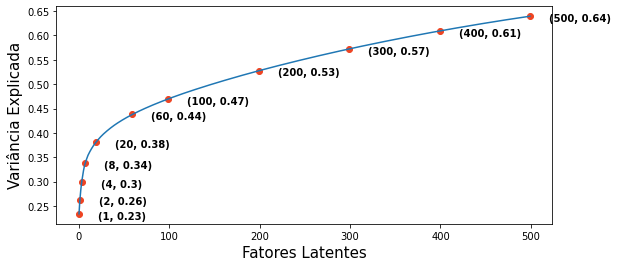

In [54]:
# Plot
fig, (ax1) = plt.subplots(nrows = 1, ncols = 1, figsize = plt.figaspect(.45))

ax1.set_ylabel("Variância Explicada", fontsize = 15)
ax1.set_xlabel("Fatores Latentes", fontsize = 15)
ax1.plot(expl_var)

# Vamos marcar algumas combinações de (fatores latentes, variância explicada) para tornar o gráfico mais claro
ind = [1, 2, 4, 8, 20, 60, 100, 200, 300, 400, 500]
ax1.scatter(x = [i-1 for i in ind], y = expl_var[[i-1 for i in ind]], c = '#ee4422')

for i in ind:
    ax1.annotate(s ="({}, {})".format(i,  np.round(expl_var[i-1], 2)), xy = (i-1, expl_var[i-1]),
                xytext = ( i+20, expl_var[i-1] - 0.01), fontweight = 'bold')

plt.show()

Com 500 componentes explicamos aproximadamente 65% da variância dos dados. 

65% é pouco? Depende. Tem capacidade computacional pra mais? Então aumenta. Mas com 65% conseguimos explicar mais da metade da variância dos dados, é razoável.

Tem que avaliar o custo (computacional) x benefício (explicabilidade da variância)

#### Vamos projetar nossa matriz no espaço de 500 dimensões. É como se a informação fosse compactada. Tem um perda, mas ainda sim é possível explicar 65% da variância

In [55]:
start = datetime.now()
trunc_matrix = matriz_esparsa_treino.dot(netflix_svd.components_.T)
print("Tempo de Processamento:", datetime.now() - start)

Tempo de Processamento: 0:00:27.248515


In [56]:
# Shape
trunc_matrix.shape

(2649430, 500)

In [60]:
# Vamos criar e salvar em disco a matriz com a a dimensionalidade reduzida para 500 dimensões
matriz_esparsa_user_truncada = sparse.csr_matrix(trunc_matrix)
sparse.save_npz('archive/matriz_esparsa_user_truncada', matriz_esparsa_user_truncada)

In [61]:
# Conferindo o shape
matriz_esparsa_user_truncada.shape

(2649430, 500)

Calculando novamente a similaridade de usuários usando a matriz reduzida (truncada).

-> Tinha uma matriz com cerca de 17 mil dimensões

-> Aplica a redução de dimensionalidade

-> Fica com uma matriz compactada de tamanho menor

-> Usa essa matriz reduzida para cálculo de similaridade

Calculando top 50 similaridades para cada usuário...
Cálculo concluído para 20 usuários [  tempo total : 0:01:49.585308  ]
Cálculo concluído para 40 usuários [  tempo total : 0:03:39.617068  ]
Criação de matriz esparsa a partir das semelhanças computadas...


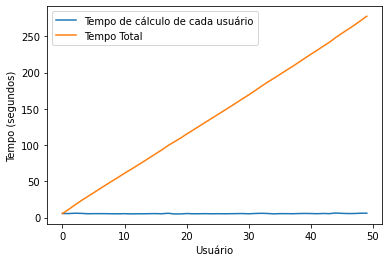

Tempo de Processamento: 0:05:10.835097


In [62]:
# Calcula similaridade de usuários com a matriz truncada

# Marca o início
start = datetime.now()

# Calcula a similaridade
trunc_sim_matrix, _ = calcula_similaridade_usuario(matriz_esparsa_user_truncada, 
                                                   compute_for_few = True, 
                                                   top = 50, 
                                                   verbose = True) 

print("Tempo de Processamento:", datetime.now() - start)

Até aqui foi feito o cálculo de similaridade entre os usuários (matriz enorme). Agora será necessário calcular a similaridade entre os filmes (menor, porque temos menos filmes que usuários).

### Calculando Matriz de Similaridade de Filmes
    Tem o problema da dimensionalidade para os filmes? Nesse caso não!!! Por quê? Porque temos uma quantidade muito maior de usuários do que de filmes.

In [63]:
# Cálculo da similaridade de filmes

# Marca o início
start = datetime.now()

matriz_esparsa_filme = cosine_similarity(X = matriz_esparsa_treino.T, dense_output = False)
print("Matriz Criada.")
sparse.save_npz("archive/matriz_esparsa_filme.npz", matriz_esparsa_filme)
print("Matriz Salva em Disco.")

print("Tempo de Processamento:", datetime.now() - start)

Matriz Criada.
Matriz Salva em Disco.
Tempo de Processamento: 0:10:28.655453


In [75]:
matriz_esparsa_filme.shape

(17771, 17771)

Dimensões bem menores. De novo, porque temos uma quantidade de filmes bem menor que a quantidade de usuários.

In [64]:
# Extra os ids dos filmes
movie_ids = np.unique(matriz_esparsa_filme.nonzero()[1])

### Proxima etapa é calcular a similaridade de filmes, de acordo com o padrão de avaliação dos usuários.
   
   **>>Unir as duas coisas**
   
   **>>similaridade de filmes com similaridade de usuários**

In [66]:
start = datetime.now()

# Dicionário para armazenar as similaridades
filmes_similares = dict()

# Loop pelos ids dos filmes
for movie in movie_ids:
    # Obtemos os top filmes semelhantes e armazenamos no dicionário
    filmes_sim = matriz_esparsa_filme[movie].toarray().ravel().argsort()[::-1][1:]
    filmes_similares[movie] = filmes_sim[:100]
    
print("Tempo de Processamento:", datetime.now() - start)

Tempo de Processamento: 0:00:29.651928


In [79]:
# Filmes similares ao filme de id 10
filmes_similares[10]

array([13003,  5995,  1282, 13832, 10635,  7626, 11423, 14121,  3981,
       17344, 13469, 13737, 13776, 17549,  9763, 12240,  5224,  4671,
       13956, 16907, 14181,  2404, 11680, 14376,  5423,  1917,   352,
       13674,  3623, 14009,  3378,  1446, 11101,  3221,   112,  3591,
        9276, 11894, 12454, 11124,  5655,  6421,  6454,  3493, 13812,
          11,  1292,  4363,  9094, 14830,  9048, 16359,  4863, 10786,
       17754, 11428, 11660, 14645, 11655, 17457, 10391,  4581, 15404,
          52, 17137, 17111,  3854,     6,  9372,  5372,  4559, 12110,
        9704,  4244,   201,  2502, 13060,  6950, 15747,  9983, 11180,
        7422,  8524,  3533, 10651,  7248, 10472,  2679, 10096,  6731,
         534,  6905, 13757, 16503,  7567,  1235,  5911, 14304,  5194,
        6551], dtype=int64)

#### Agora vamos encontrar os filmes mais semelhantes usando a matriz de similaridade.

In [68]:
# Vamos carregar os títulos dos filmes do arquivo csv fornecido pela Netflix
titulos_filmes = pd.read_csv("archive/movie_titles.csv", 
                             sep = ',', 
                             header = None,
                             names = ['ID_Filme', 'Ano_Lancamento', 'Titulo'], 
                             verbose = True,
                             index_col = 'ID_Filme', 
                             encoding = "ISO-8859-1")

Tokenization took: 4.99 ms
Type conversion took: 9.01 ms
Parser memory cleanup took: 0.00 ms


In [69]:
# Visualiza os dados
titulos_filmes.head()

,Ano_Lancamento,Titulo
ID_Filme,,
1,2003.0,Dinosaur Planet
2,2004.0,Isle of Man TT 2004 Review
3,1997.0,Character
4,1994.0,Paula Abdul's Get Up & Dance
5,2004.0,The Rise and Fall of ECW


### Vejamos quais são os filmes similares ao filme de ID 43.

In [84]:
# ID do filme
id_filme = 10

In [85]:
# Print
print("Filme:", titulos_filmes.loc[id_filme].values[1])
print("Total de Avaliações de Usuários = {}.".format(matriz_esparsa_treino[:,id_filme].getnnz()))
print("Encontramos {} filmes que são similares a este e vamos imprimir os mais similares.".format(matriz_esparsa_filme[:,id_filme].getnnz()))

Filme: Fighter
Total de Avaliações de Usuários = 221.
Encontramos 17282 filmes que são similares a este e vamos imprimir os mais similares.


In [86]:
# Encontrando todas as similaridades
similaridades = matriz_esparsa_filme[id_filme].toarray().ravel()
similar_indices = similaridades.argsort()[::-1][1:]
similaridades[similar_indices]
sim_indices = similaridades.argsort()[::-1][1:] 

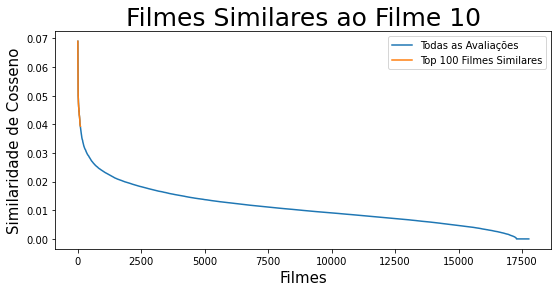

In [87]:
# Plot
fig = plt.figure(figsize = plt.figaspect(.45))
plt.plot(similaridades[sim_indices], label = 'Todas as Avaliações')
plt.plot(similaridades[sim_indices[:100]], label = 'Top 100 Filmes Similares')
plt.title("Filmes Similares ao Filme {}".format(id_filme), fontsize = 25)
plt.xlabel("Filmes", fontsize = 15)
plt.ylabel("Similaridade de Cosseno", fontsize = 15)
plt.legend()
plt.show()

In [88]:
# Aqui os top 10 filmes mais similares ao filme 43
titulos_filmes.loc[sim_indices[:10]]

,Ano_Lancamento,Titulo
ID_Filme,,
13003,1999.0,The Jaundiced Eye
5995,1997.0,The Long Way Home
1282,2002.0,Blind Spot: Hitler's Secretary
13832,1999.0,Keep the River on Your Right: A Modern Canniba...
10635,2001.0,Go Tigers!
7626,2001.0,The Sweetest Sound
11423,1998.0,Little Dieter Needs to Fly
14121,2004.0,Deadline
3981,2003.0,S21: The Khmer Rouge Killing Machine


### Próximo passo - ML para fazer previsões